In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle
from tqdm import tqdm

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
sys.path.append('/home/hiroki/research/dcase2021_task2/src/model_codes/MahalanobisAD')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
#from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'

os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_by_GMM/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'valid_source', 'valid_target']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

# GMM AD by likelihood

## estimate

In [103]:
def load_gmm(machine_type, n_components):
    gmm = pd.read_pickle(f'{MODEL_DIR}/{machine_type}/{machine_type}_model_n={n_components}.pkl')
    return gmm

In [118]:
gmm = load_gmm(machine_types[0], 2)

In [124]:
gmm.predict_proba(X).shape

(600, 2)

In [127]:
# https://www.slideshare.net/ChihiroKusunoki/ss-98822807
# page.4

class GMM_estimator():
    def __init__(self, gmm, precisions_Cholesky=False):
        
        super(GMM_estimator, self).__init__()
        self.gmm = gmm
        self.K = gmm.n_components
        self.weights = gmm.weights_
        if precisions_Cholesky == True:
            self.precisions = gmm.precisions_cholesky_
        else:
            self.precisions = gmm.precisions_
        self.cov = gmm.covariances_
        self.means = gmm.means_
    
    def calc_energy(self, X):
        pred = self.gmm.predict_proba(X)
        sum_terms = []
        for k in range(self.K):
            # クラスタk番目の尤度
            likelihood = multivariate_normal.logpdf(X, mean=gmm.means_[k,:], cov=gmm.covariances_[k,:,:])
            # 混合比 * 尤度
            sum_term = likelihood * self.weights[k]
            sum_terms.append(sum_term)
        # 総和項
        sum_terms = np.array(sum_terms)
        # 負の対数
        log_term = sum_terms.sum(axis=0)
        energy = -np.log(log_term)
        
        return energy

2021-03-29 21:02:38,234 - 00_train.py - INFO - fan valid_source AUC : 0.5407222222222222


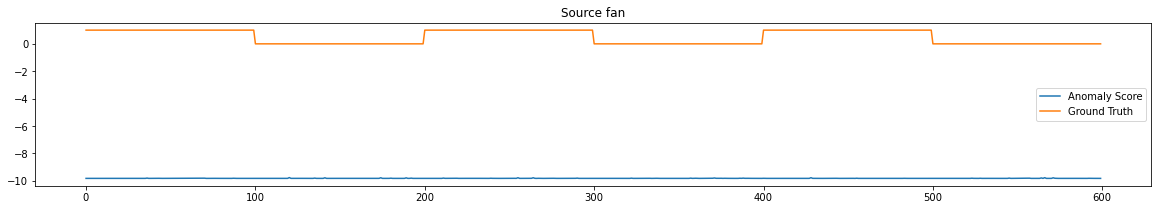

2021-03-29 21:02:45,272 - 00_train.py - INFO - fan valid_target AUC : 0.5893666666666666


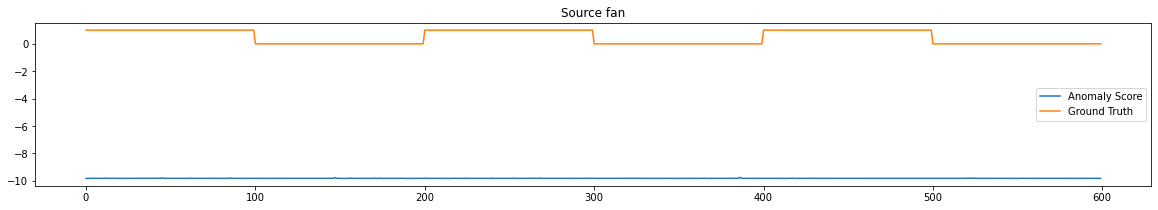

2021-03-29 21:02:52,751 - 00_train.py - INFO - gearbox valid_source AUC : 0.5005302888514567


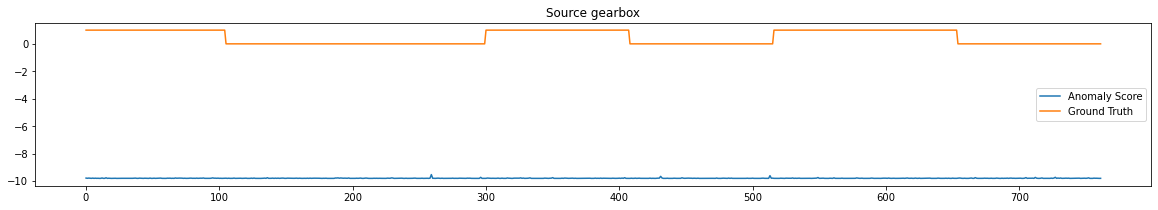

2021-03-29 21:03:00,182 - 00_train.py - INFO - gearbox valid_target AUC : 0.5172792417938049


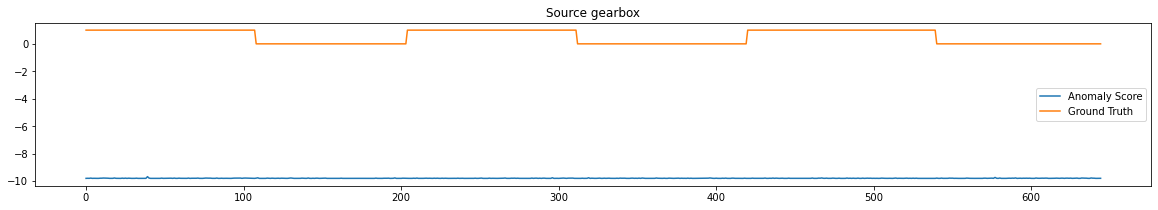

2021-03-29 21:03:07,998 - 00_train.py - INFO - pump valid_source AUC : 0.5846


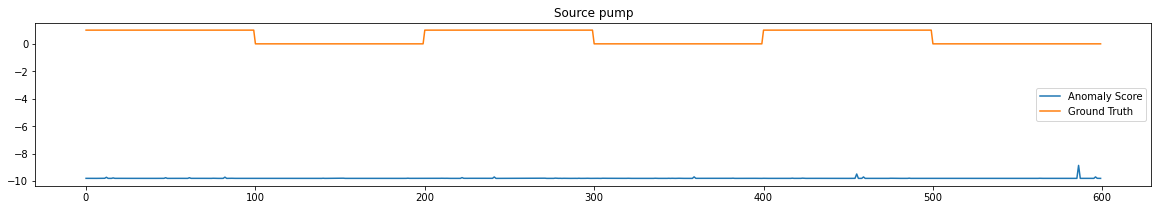

2021-03-29 21:03:14,697 - 00_train.py - INFO - pump valid_target AUC : 0.5237222222222222


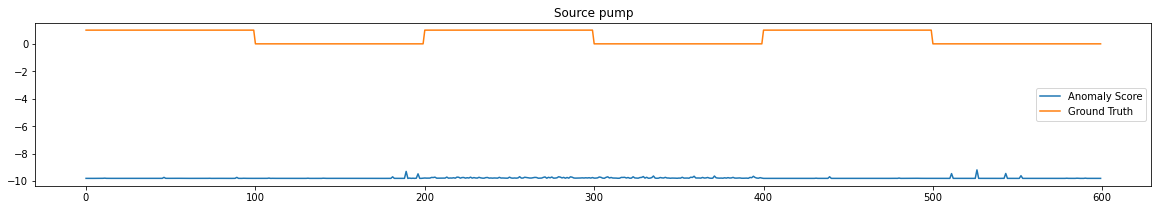

2021-03-29 21:03:21,717 - 00_train.py - INFO - slider valid_source AUC : 0.5787865840632342


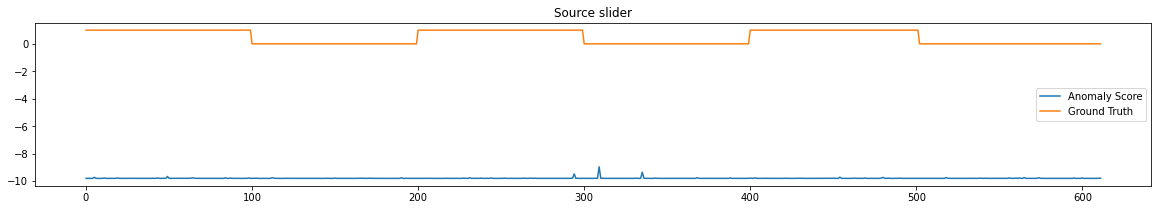

2021-03-29 21:03:28,603 - 00_train.py - INFO - slider valid_target AUC : 0.5910264900662252


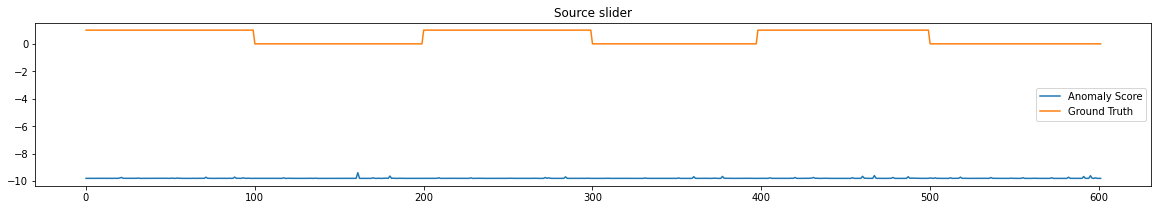

2021-03-29 21:03:36,277 - 00_train.py - INFO - ToyCar valid_source AUC : 0.5131444444444445


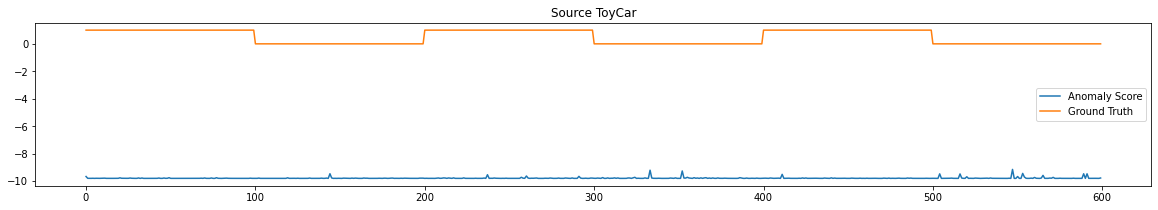

2021-03-29 21:03:44,550 - 00_train.py - INFO - ToyCar valid_target AUC : 0.5082333333333333


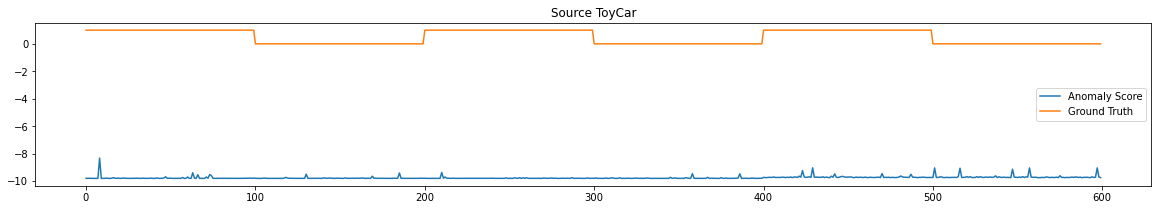

2021-03-29 21:03:51,712 - 00_train.py - INFO - ToyTrain valid_source AUC : 0.47315555555555555


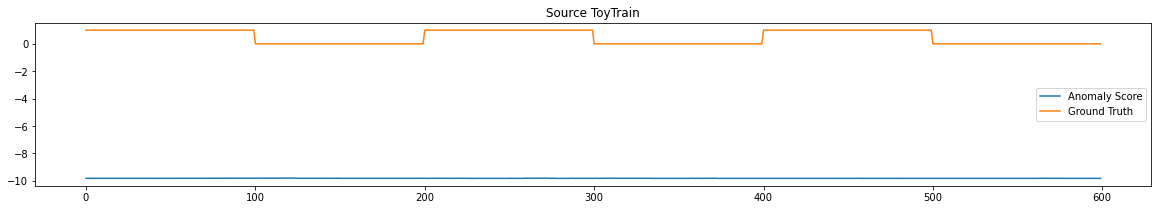

2021-03-29 21:03:58,604 - 00_train.py - INFO - ToyTrain valid_target AUC : 0.5173000000000001


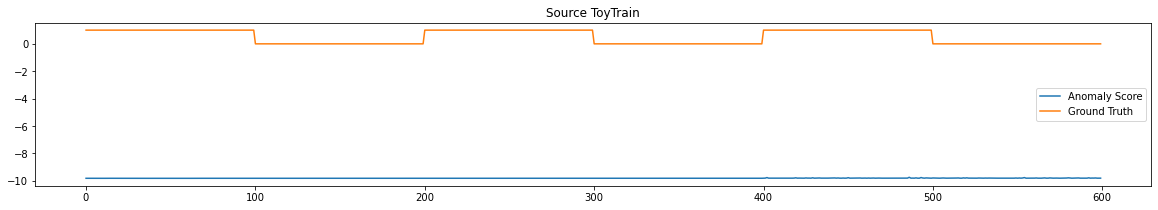

2021-03-29 21:04:06,295 - 00_train.py - INFO - valve valid_source AUC : 0.5148444444444444


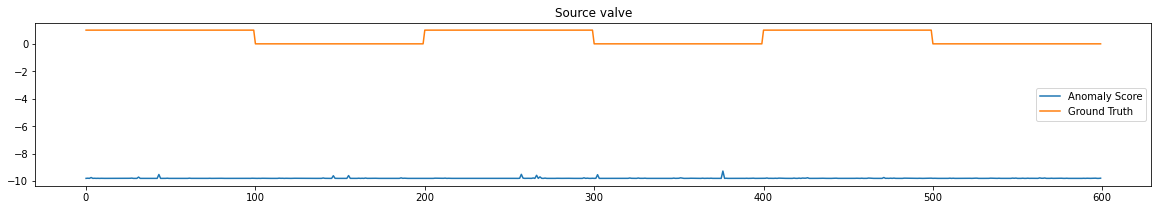

2021-03-29 21:04:13,678 - 00_train.py - INFO - valve valid_target AUC : 0.5360555555555555


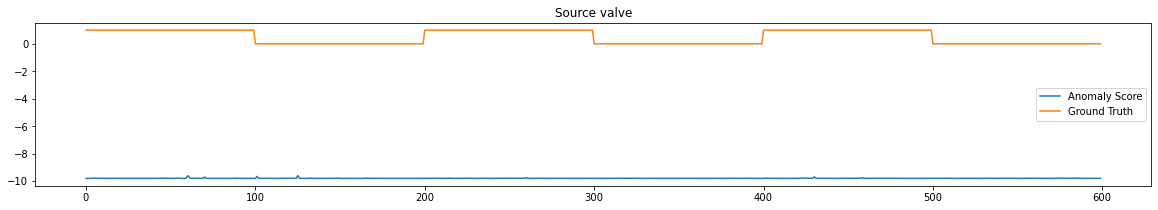

In [128]:
n_components = 2

for machine_type in machine_types:
    # load data
    ext_data = load_ext_data(machine_type)
    # load gmm
    gmm = load_gmm(machine_type, n_components)
    # inference and calc AUC
    for phase in ['valid_source', 'valid_target']:
        features = ext_data[phase]['features']
        labels = ext_data[phase]['labels']
        est = GMM_estimator(gmm, precisions_Cholesky=False)
        anomaly_score = est.calc_energy(features)
        roc_auc = roc_auc_score(labels, anomaly_score)
        logger.info(f'{machine_type} {phase} AUC : {roc_auc}')
        # plot
        plt.figure(figsize=(20,3))
        plt.title(f'Source {machine_type}')
        plt.plot(anomaly_score, label='Anomaly Score')
        plt.plot(labels, label='Ground Truth')
        plt.legend()
        plt.show()

# GMM AD by weighted mahalanobis

In [308]:
def Calc_GMM_mahalanobis(gmm, features, labels):
    means = gmm.means_
    cov_inv = gmm.precisions_
    K = gmm.n_components
    pred_proba = gmm.predict_proba(features)
    mahalanobis_K = []
    for k in range(K):
        mahalanobis_k = [mahalanobis(sample, means[k,:], cov_inv[k,:,:]) for sample in features]
        mahalanobis_k = np.array(mahalanobis_k)
        mahalanobis_K.append(mahalanobis_k)
    mahalanobis_K = np.array(mahalanobis_K)
    anomaly_score = np.multiply(mahalanobis_K.T, pred_proba)
    anomaly_score = anomaly_score.sum(axis=1)
    
    return anomaly_score

2021-03-26 22:28:30,508 - 00_train.py - INFO - fan valid_source AUC : 0.5805


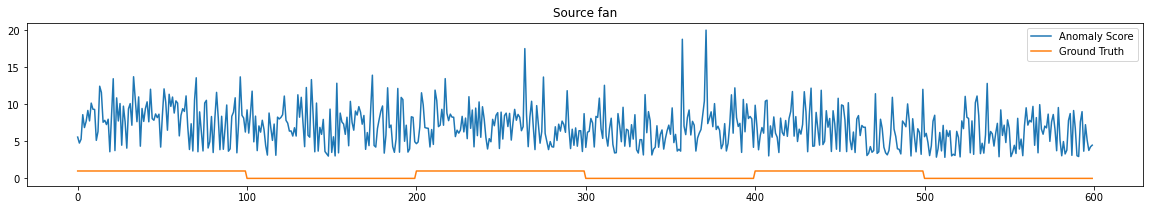

2021-03-26 22:28:35,297 - 00_train.py - INFO - fan valid_target AUC : 0.6065555555555555


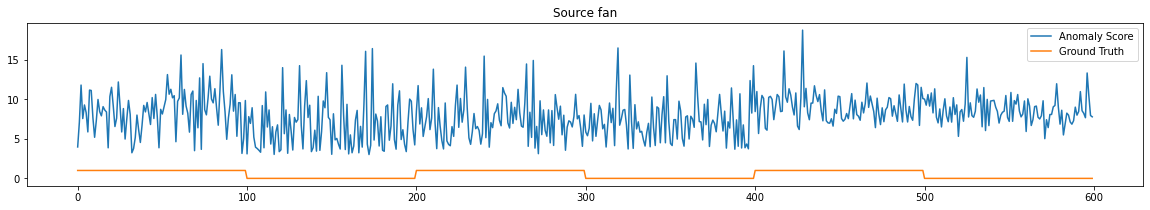

2021-03-26 22:28:41,757 - 00_train.py - INFO - gearbox valid_source AUC : 0.6225591116102065


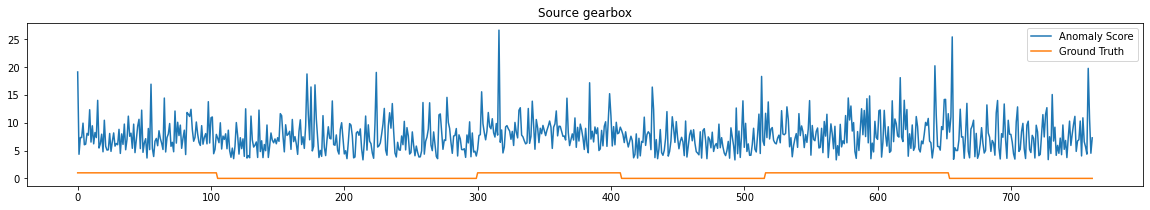

2021-03-26 22:28:47,416 - 00_train.py - INFO - gearbox valid_target AUC : 0.6986823855755896


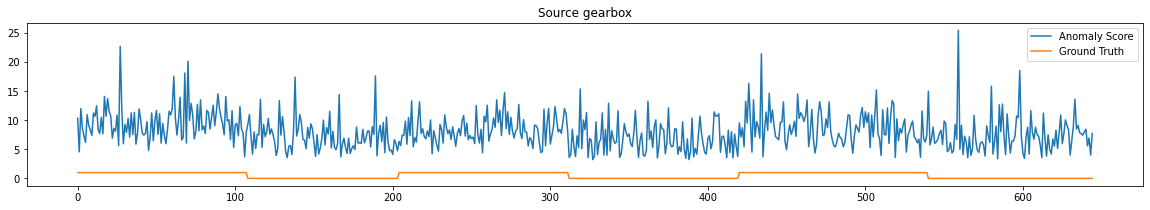

2021-03-26 22:28:52,502 - 00_train.py - INFO - pump valid_source AUC : 0.5964333333333334


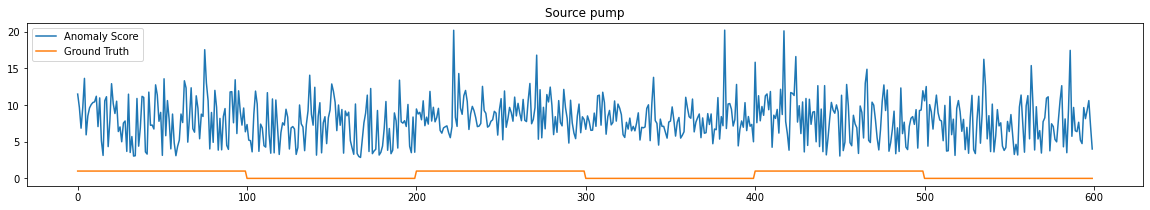

2021-03-26 22:28:57,613 - 00_train.py - INFO - pump valid_target AUC : 0.5336666666666667


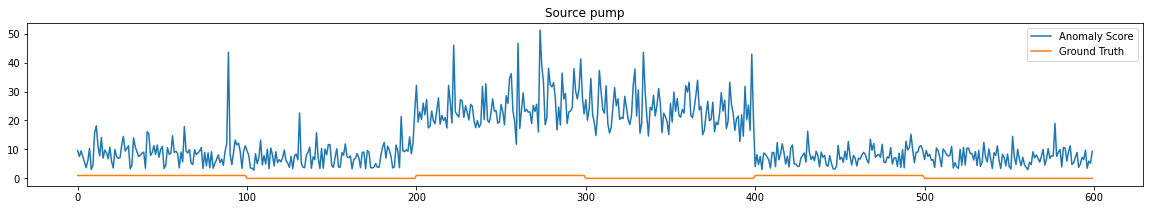

2021-03-26 22:29:03,005 - 00_train.py - INFO - slider valid_source AUC : 0.6709250160222175


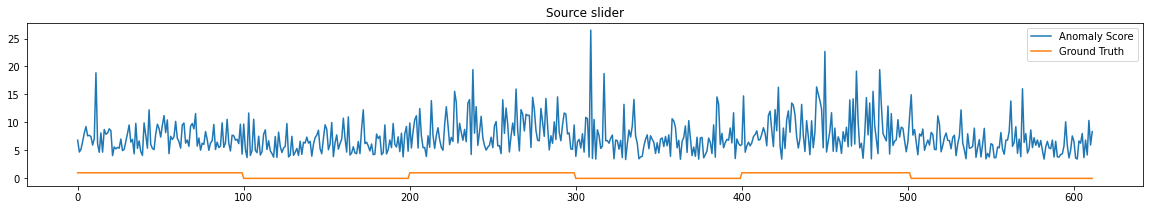

2021-03-26 22:29:08,049 - 00_train.py - INFO - slider valid_target AUC : 0.6192825607064019


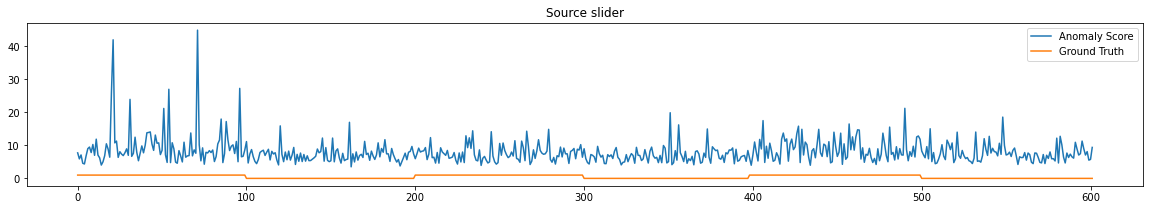

2021-03-26 22:29:13,350 - 00_train.py - INFO - ToyCar valid_source AUC : 0.6221444444444445


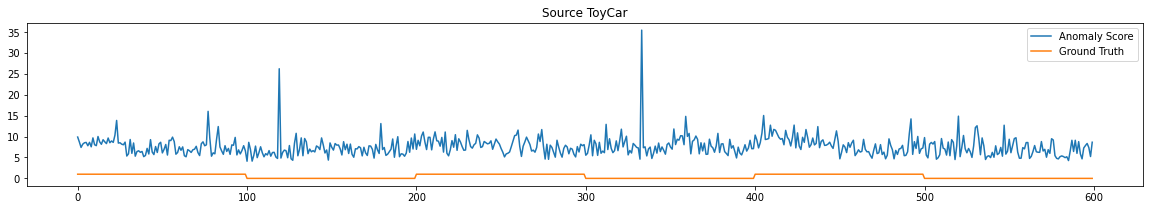

2021-03-26 22:29:18,430 - 00_train.py - INFO - ToyCar valid_target AUC : 0.5476000000000001


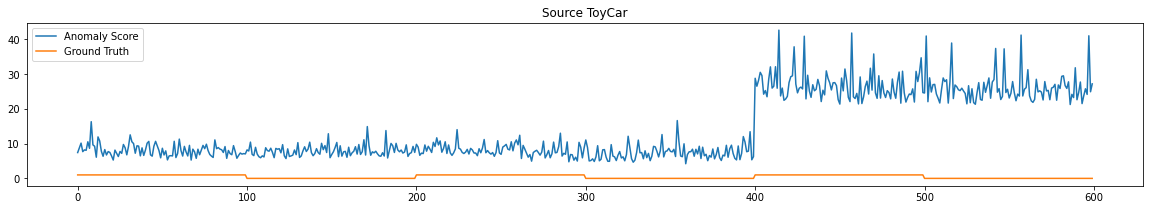

2021-03-26 22:29:23,481 - 00_train.py - INFO - ToyTrain valid_source AUC : 0.5802555555555555


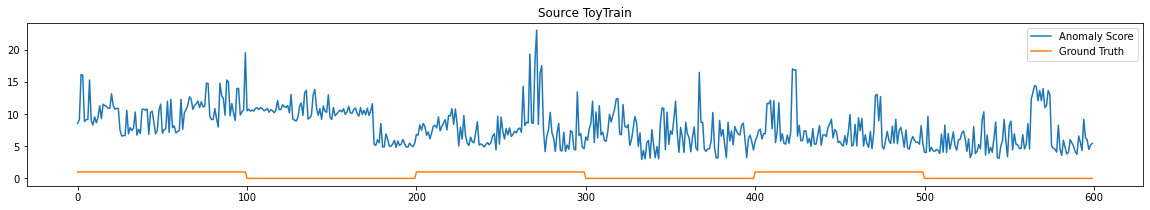

2021-03-26 22:29:28,516 - 00_train.py - INFO - ToyTrain valid_target AUC : 0.4806777777777778


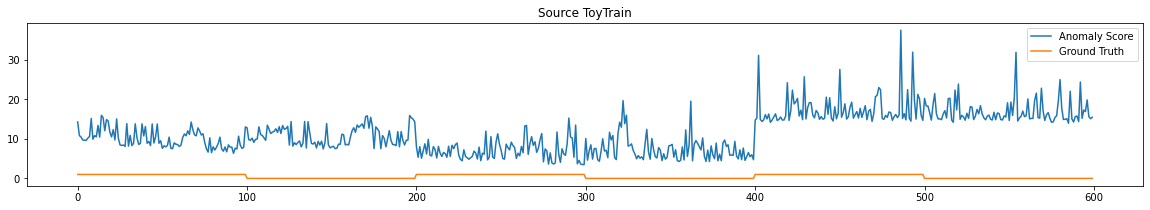

2021-03-26 22:29:33,578 - 00_train.py - INFO - valve valid_source AUC : 0.5328555555555555


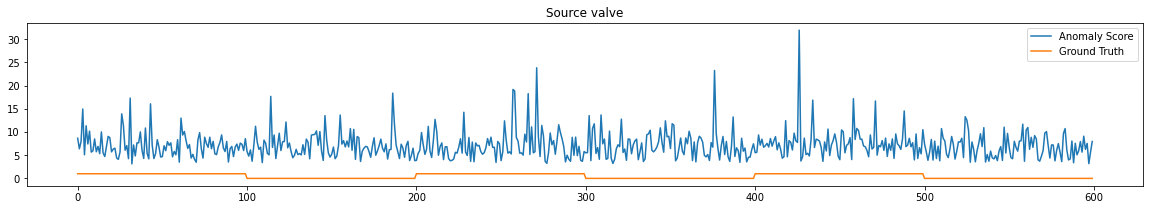

2021-03-26 22:29:38,582 - 00_train.py - INFO - valve valid_target AUC : 0.5482888888888888


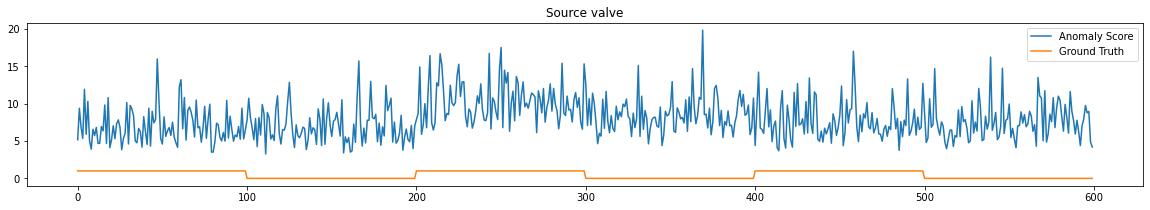

In [309]:
n_components = 2

for machine_type in machine_types:
    # load data
    ext_data = load_ext_data(machine_type)
    # load gmm
    gmm = load_gmm(machine_type, n_components)
    # inference and calc AUC
    for phase in ['valid_source', 'valid_target']:
        features = ext_data[phase]['features']
        labels = ext_data[phase]['labels']
        anomaly_score = Calc_GMM_mahalanobis(gmm, features, labels)
        roc_auc = roc_auc_score(labels, anomaly_score)
        logger.info(f'{machine_type} {phase} AUC : {roc_auc}')
        # plot
        plt.figure(figsize=(20,3))
        plt.title(f'Source {machine_type}')
        plt.plot(anomaly_score, label='Anomaly Score')
        plt.plot(labels, label='Ground Truth')
        plt.legend()
        plt.show()

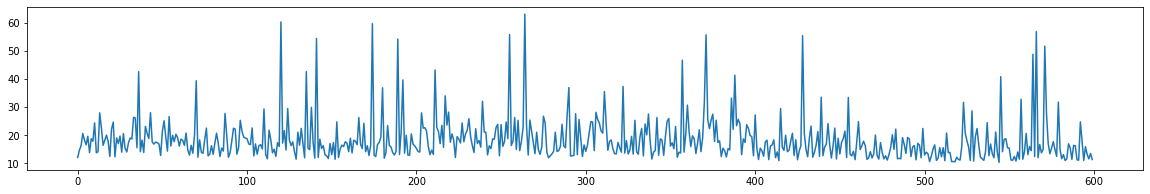

In [292]:
plt.figure(figsize=(20,3))
plt.plot(anomaly_score)

In [ ]:
for machine_type in machine_types:
    # get gmm
    means = gmm.means_
    cov_inv = gmm.precisions_
    # load data
    ext_data = load_ext_data(machine_type)
    for k in range(K):
        # calc mahalanobis (Anomaly Score)
        valid_source_dists = [mahalanobis(sample, means[k,:,:], cov_inv[k,:,:]) for sample in ext_data['valid_source']['features']]
        valid_target_dists = [mahalanobis(sample, mean[k,:,:], cov_inv[k,:,:]) for sample in ext_data['valid_target']['features']]
        # np.array
        valid_source_dists = np.array(valid_source_dists)
        valid_target_dists = np.array(valid_target_dists)
        
    
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

In [275]:
maha = mahalanobis(X[1], gmm.means_[1,:], gmm.precisions_[1,:,:])

In [276]:
maha

9.813471726254788

In [82]:
%%time

machine_type = machine_types[0]
n_components = 2

X = load_ext_data(machine_type)['valid_source']['features']
gmm = load_gmm(machine_type, n_components)
estimator = GMM_estimator(gmm, precisions_Cholesky=True)

valid_source_energy = estimator.calc_energy(X)

#sample_energy = calc_energy(gmm, x, precisions_Cholesky=False)

ValueError: operands could not be broadcast together with shapes (3072,600) (3072,3072) 

In [ ]:
for machine_type in machine_types:
    # load model
    gmm = pd.read_pickle(gmm, f'{outdir}/{machine_type}_model_n={n_components}.pkl')
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## GMM param tune

In [10]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [22]:
n_components_list = [2,3,4]

for machine_type in machine_types:
    logger.info(f'====== {machine_type} ======')
    ext_data = load_ext_data(machine_type)
    outdir = f'{MODEL_DIR}/{machine_type}'
    os.makedirs(outdir, exist_ok=True)
    bic_list = []
    for n_components in n_components_list:
        logger.info(f'n_components = {n_components}')
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(ext_data['train']['features'])
        bic = gmm.bic(ext_data['train']['features'])
        logger.info(f'{bic}')
        pd.to_pickle(gmm, f'{outdir}/{machine_type}_model_n={n_components}.pkl')

2021-03-26 00:12:09,833 - 00_train.py - INFO - ====== fan ======
2021-03-26 00:12:09,853 - 00_train.py - INFO - n_components = 2
2021-03-26 00:13:18,696 - 00_train.py - INFO - -34506477.68973705
2021-03-26 00:13:20,647 - 00_train.py - INFO - n_components = 3
2021-03-26 00:15:06,223 - 00_train.py - INFO - 3266251.7302385718
2021-03-26 00:15:08,933 - 00_train.py - INFO - n_components = 4
2021-03-26 00:18:52,474 - 00_train.py - INFO - 41069160.35474008
2021-03-26 00:18:56,150 - 00_train.py - INFO - ====== gearbox ======
2021-03-26 00:18:56,171 - 00_train.py - INFO - n_components = 2
2021-03-26 00:19:48,358 - 00_train.py - INFO - -34955127.82901172
2021-03-26 00:19:50,215 - 00_train.py - INFO - n_components = 3
2021-03-26 00:22:58,047 - 00_train.py - INFO - 2850855.2361516804
2021-03-26 00:23:00,841 - 00_train.py - INFO - n_components = 4
2021-03-26 00:26:05,410 - 00_train.py - INFO - 40692933.317038804
2021-03-26 00:26:09,111 - 00_train.py - INFO - ====== pump ======
2021-03-26 00:26:09,1

In [16]:
gmm.bic(ext_data['train']['features'])

3319258.8933906704

In [22]:
pred = gmm.predict(ext_data['train']['features'])

(array([ 790.,    0.,    0.,    0.,    0.,  378.,    0.,    0.,    0.,
        1841.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

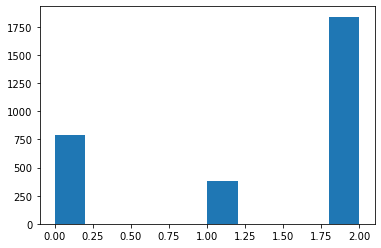

In [27]:
plt.hist(pred)

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [75]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [ ]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

In [71]:
gmm_section_types = gmm.predict(feats)

/home/hiroki/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

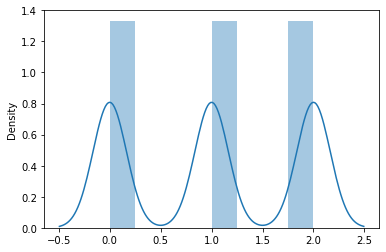

In [75]:
sns.distplot(section_types)

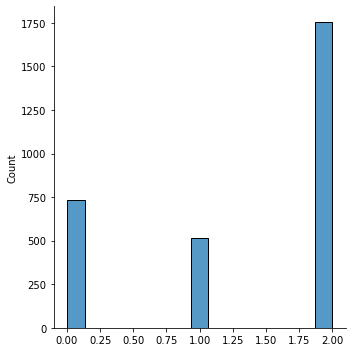

In [74]:
sns.displot(gmm_section_types)